# Import needed modules

In [ ]:
!pip install captum
!pip install opencv-python
!pip install torchsummary kagglehub efficientnet_pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from itertools import combinations
from torchvision.models import efficientnet_b0
import numpy as np
from model import UNET, Discriminator
import matplotlib.pyplot as plt
import random
from itertools import combinations
import numpy as np
from captum.attr import LayerGradCam
import kagglehub
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

c:\Users\navan\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [3]:
class AddNoiseTransform: 
    def __init__(self, noise_probabilities=None):
        self.noise_probabilities = noise_probabilities or {
            'gaussian': 0.3,
            'salt_and_pepper': 0.2,
            'speckle': 0.2,
            'low_frequency': 0.3,
            'quantization': 0.2
        }
        self.noise_types = ['gaussian', 'salt_and_pepper', 'speckle', 'low_frequency', 'quantization']
    
    def __call__(self, image):
        if image.ndim < 2:
            raise ValueError("Input image must have at least 2 dimensions (height and width).")

        all_combinations = self.get_all_combinations()
        selected_combination = random.choice(all_combinations)

        applied_noises = []
        for noise in selected_combination:
            if random.random() < self.noise_probabilities[noise]:
                image = self.apply_noise(image, noise)
                applied_noises.append(noise)
        
        return image, applied_noises

    def apply_noise(self, image, noise):
        if noise == 'gaussian':
            return self.add_gaussian_noise(image)
        elif noise == 'salt_and_pepper':
            return self.add_salt_and_pepper_noise(image)
        elif noise == 'speckle':
            return self.add_speckle_noise(image)
        elif noise == 'low_frequency':
            return self.add_low_frequency_noise(image)
        elif noise == 'quantization':
            return self.add_quantization_noise(image)
        return image

    def get_all_combinations(self):
        all_combinations = [[]]
        for r in range(1, len(self.noise_types) + 1):
            for combo in combinations(self.noise_types, r):
                all_combinations.append(combo)
        return all_combinations

    def add_gaussian_noise(self, image):
        noise_factor = 0.1
        return image + noise_factor * torch.randn_like(image)

    def add_salt_and_pepper_noise(self, image):
        s_vs_p = 0.5
        amount = 0.04 
        out = image.clone()
        num_salt = int(amount * image.numel() * s_vs_p)
        if num_salt > 0:
            coords = [torch.randint(0, i, (num_salt,)) for i in image.shape]
            out[tuple(coords)] = 1 
        num_pepper = int(amount * image.numel() * (1. - s_vs_p))
        if num_pepper > 0:
            coords = [torch.randint(0, i, (num_pepper,)) for i in image.shape]
            out[tuple(coords)] = 0
        return out

    def add_speckle_noise(self, image):
        noise = torch.randn_like(image)
        return image + image * noise * 0.1

    def add_low_frequency_noise(self, image):
        freq = 0.1
        noise = torch.sin(torch.arange(image.size(0)) * freq)[:, None] * torch.sin(torch.arange(image.size(1)) * freq)
        return image + noise * 0.05

    def add_quantization_noise(self, image):
        return torch.round(image * 255) / 255

def add_noise(image):
    noisy_image, applied_noises = AddNoiseTransform()(image)
    noise_display = ", ".join(applied_noises) if applied_noises else "No noise"
    return noisy_image, noise_display

In [5]:
class NoisyImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        noisy_image, noise_display = add_noise(image)
        return image, noisy_image, label, noise_display

In [6]:
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")
path = path + '/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'+'/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
dataset = NoisyImageFolder(path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
]))

train_size = int(0.8 * len(dataset))

train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
# ])

# train_dataset = NoisyImageFolder('train', transform=data_transforms)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# val_dataset = NoisyImageFolder('val', transform=data_transforms)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# test_dataset = NoisyImageFolder('test', transform=data_transforms)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

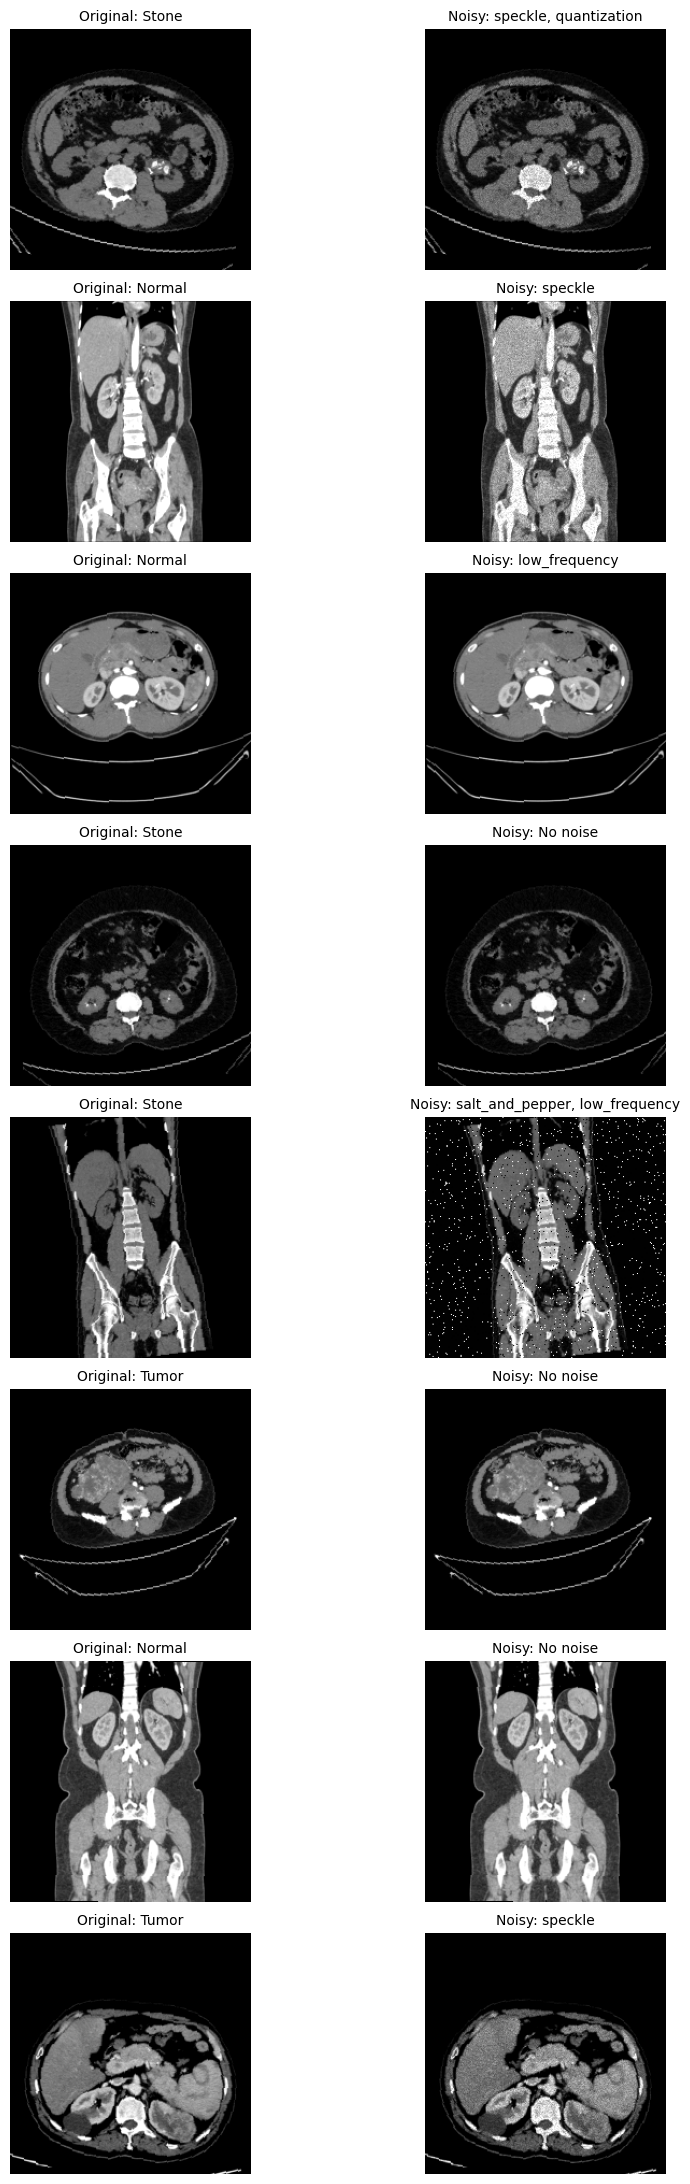

In [8]:
def visualize_original_and_noisy_images(data_loader):
    data_iter = iter(data_loader)
    original_images, noisy_images, labels, noise_types = next(data_iter)
    
    original_images = original_images.numpy().clip(0, 1)
    noisy_images = noisy_images.numpy().clip(0, 1)

    num_images = len(original_images)
    num_to_display = min(num_images, 10)
    fig, axes = plt.subplots(num_to_display, 2, figsize=(10, num_to_display * 3))

    for i in range(num_to_display):
        ax = axes[i, 0]
        ax.imshow(original_images[i].squeeze(), cmap='gray')
        ax.set_title(f'Original: {dataset.classes[labels[i]]}', fontsize=10)
        ax.axis('off')
        ax = axes[i, 1]
        ax.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title(f'Noisy: {noise_types[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

visualize_original_and_noisy_images(train_loader)

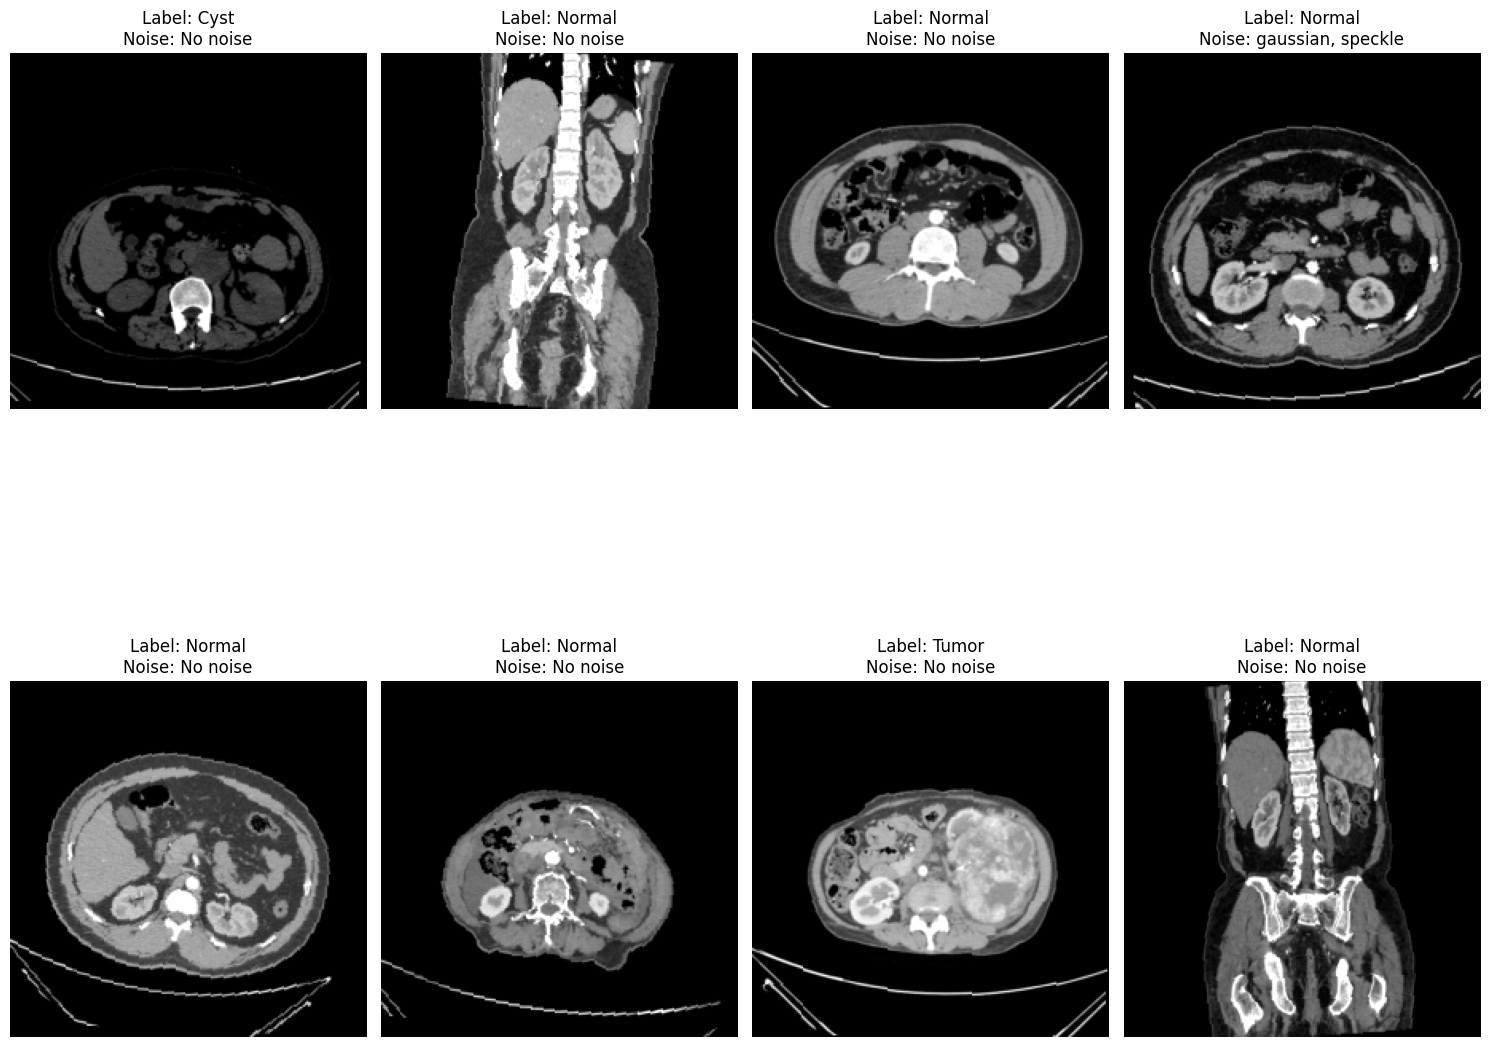

In [14]:
data_iter = iter(train_loader)
images, noisy_images, labels, noise_types = next(data_iter)
images = (images.numpy().transpose((0, 2, 3, 1))).clip(0, 1)
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i],cmap='grey')
        ax.set_title(f'Label: {dataset.classes[labels[i]]}\nNoise: {noise_types[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
generator = UNET().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

In [10]:
generator_losses = []
discriminator_losses = []

In [86]:
best_g_loss = float('inf')
num_epochs = 80
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    total_g_loss = 0.0
    total_d_loss = 0.0

    for batch_idx, (original_images, noisy_images, labels, noise_types) in enumerate(train_loader):
        original_images, noisy_images, labels = original_images.to(device), noisy_images.to(device), labels.to(device)
        real_labels = torch.ones((noisy_images.size(0), 1)).to(device)
        fake_labels = torch.zeros((noisy_images.size(0), 1)).to(device)
        optimizer_G.zero_grad()
        denoised_images = generator(noisy_images)
        g_adv_loss = adversarial_loss(discriminator(denoised_images), real_labels)
        g_l1_loss = l1_loss(denoised_images, original_images)
        g_loss = g_adv_loss + 100 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(original_images), real_labels)
        fake_loss = adversarial_loss(discriminator(denoised_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    generator_losses.append(avg_g_loss)
    discriminator_losses.append(avg_d_loss)

    print(f"[Epoch {epoch + 1}/{num_epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        torch.save(generator.state_dict(), 'generator_best.pth')
        print(f"Generator model saved at epoch {epoch + 1} with loss {best_g_loss:.4f}")
        torch.save(discriminator.state_dict(), 'discriminator_best.pth')
        print(f"Discriminator model saved at epoch {epoch + 1} with loss {best_g_loss:.4f}")

[Epoch 1/80] [D loss: 50.0000] [G loss: 1.3740]
Generator model saved at epoch 1 with loss 1.3740
Discriminator model saved at epoch 1 with loss 1.3740
[Epoch 2/80] [D loss: 50.0000] [G loss: 1.2124]
Generator model saved at epoch 2 with loss 1.2124
Discriminator model saved at epoch 2 with loss 1.2124
[Epoch 3/80] [D loss: 50.0000] [G loss: 1.2028]
Generator model saved at epoch 3 with loss 1.2028
Discriminator model saved at epoch 3 with loss 1.2028
[Epoch 4/80] [D loss: 50.0000] [G loss: 1.1106]
Generator model saved at epoch 4 with loss 1.1106
Discriminator model saved at epoch 4 with loss 1.1106
[Epoch 5/80] [D loss: 50.0000] [G loss: 1.1487]
[Epoch 6/80] [D loss: 50.0000] [G loss: 1.1524]
[Epoch 7/80] [D loss: 50.0000] [G loss: 1.0958]
Generator model saved at epoch 7 with loss 1.0958
Discriminator model saved at epoch 7 with loss 1.0958
[Epoch 8/80] [D loss: 50.0000] [G loss: 1.0443]
Generator model saved at epoch 8 with loss 1.0443
Discriminator model saved at epoch 8 with loss

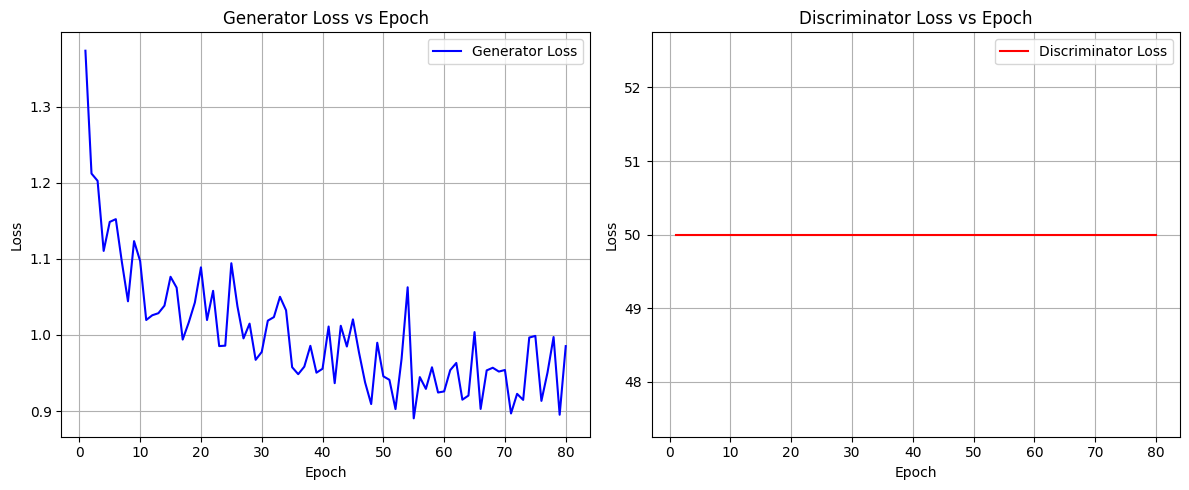

In [87]:
epochs = range(1, num_epochs + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, generator_losses, label='Generator Loss', color='blue')
axs[0].set_title('Generator Loss vs Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

axs[1].plot(epochs, discriminator_losses, label='Discriminator Loss', color='red')
axs[1].set_title('Discriminator Loss vs Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

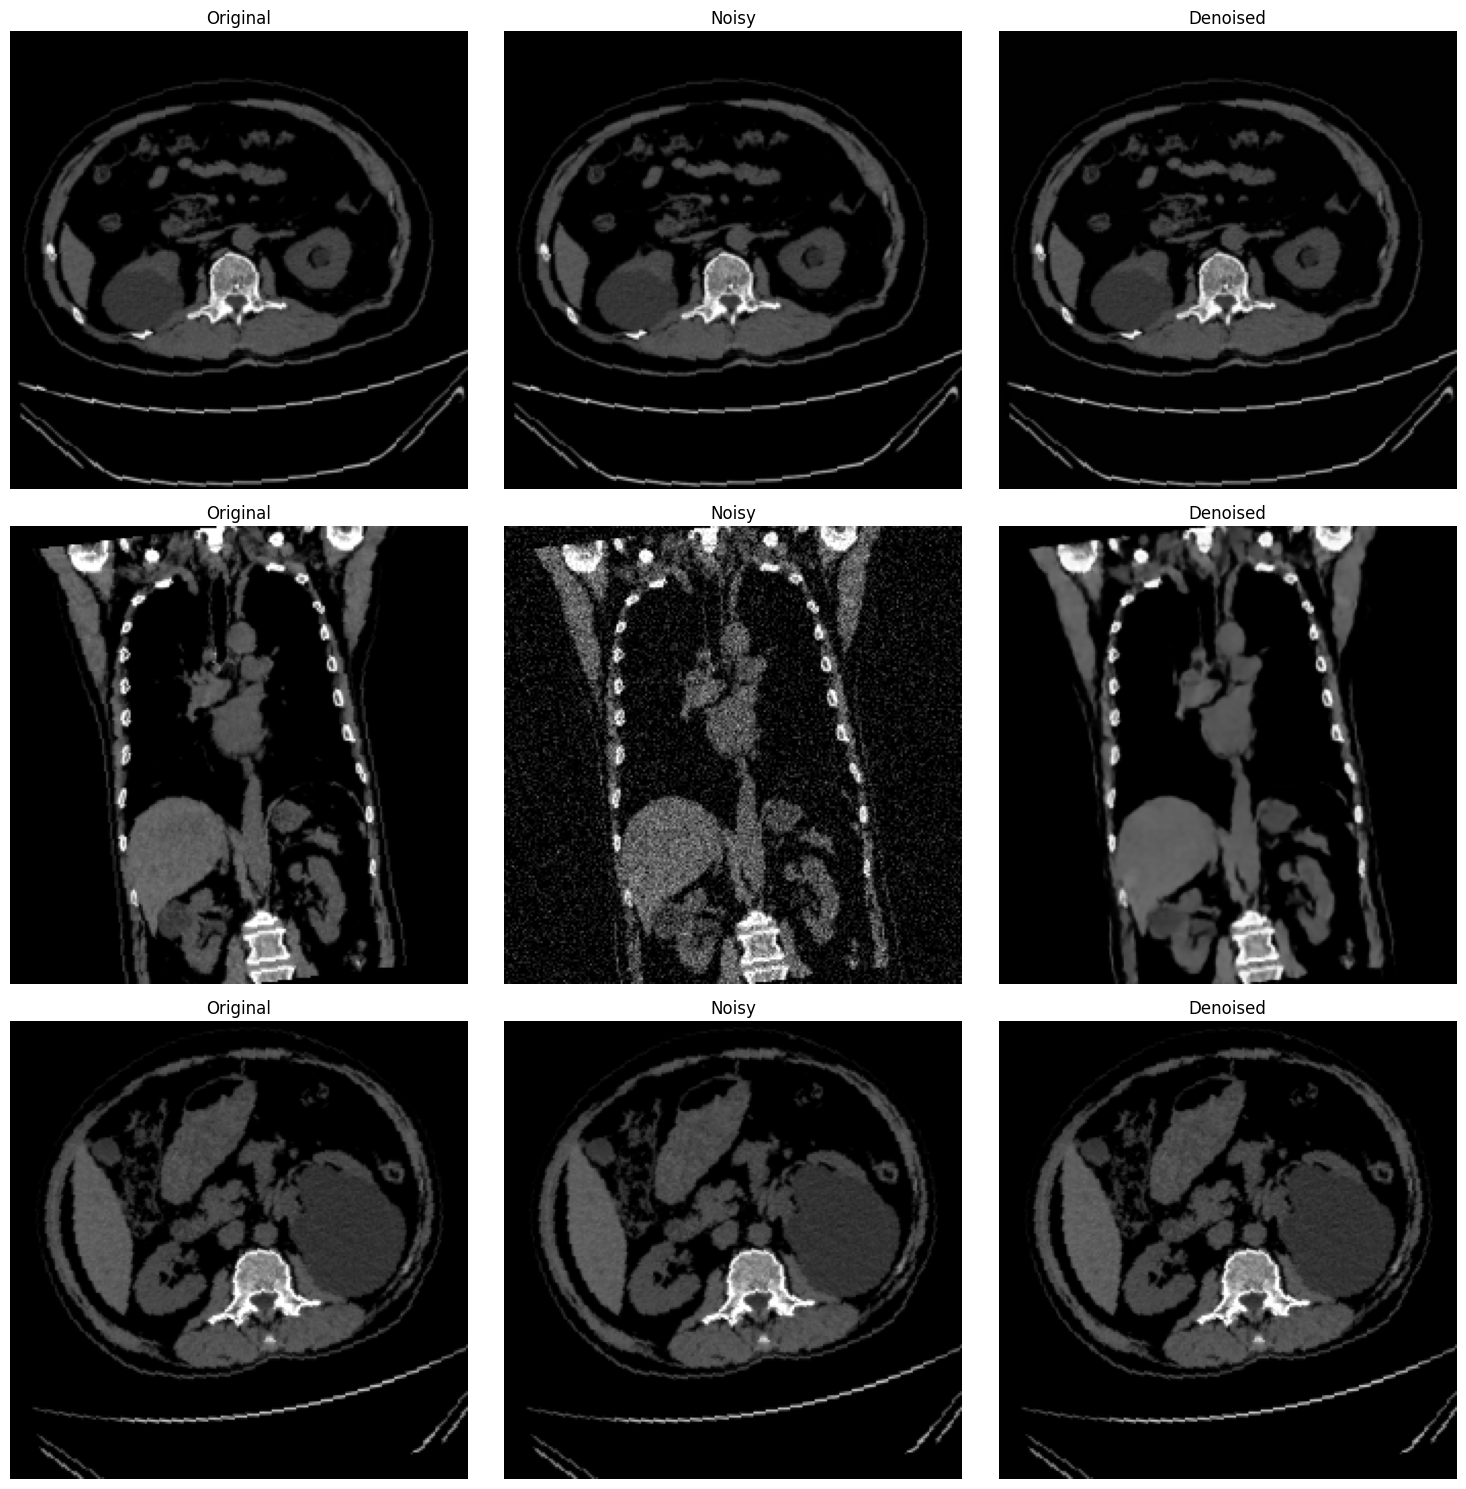

In [18]:
generator.load_state_dict(torch.load('generator_best.pth'))
discriminator.load_state_dict(torch.load('discriminator_best.pth'))

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
reconstructed_images = generator(noisy_images)
original_images = original_images.cpu().detach().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
noisy_images = noisy_images.cpu().detach().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
reconstructed_images = reconstructed_images.cpu().detach().numpy().transpose((0, 2, 3, 1)).clip(0, 1)

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(original_images[i].squeeze(), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(noisy_images[i].squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def compute_snr(original_images, noisy_images, reconstructed_images):
    original_images = original_images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()
    original_images /= 255.0
    noisy_images /= 255.0
    reconstructed_images /= 255.0
    eps = 1e-10
    snr_noisy = np.mean(np.square(original_images) / (np.square(original_images - noisy_images) + eps))
    snr_reconstructed = np.mean(np.square(original_images) / (np.square(original_images - reconstructed_images) + eps))
    return snr_noisy, snr_reconstructed

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
reconstructed_images = generator(noisy_images)
snr_noisy, snr_reconstructed = compute_snr(original_images, noisy_images, reconstructed_images)
snr_noisy_db = 10 * np.log10(snr_noisy)
snr_reconstructed_db = 10 * np.log10(snr_reconstructed)
print(f'SNR (Noisy): {snr_noisy_db:.2f} dB')
print(f'SNR (Reconstructed): {snr_reconstructed_db:.2f} dB')

SNR (Noisy): 39.54 dB
SNR (Reconstructed): 43.43 dB


In [14]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [39]:
model = efficientnet_b0(pretrained=True)
model.features[0][0] = torch.nn.Conv2d(
    in_channels=1,
    out_channels=model.features[0][0].out_channels,
    kernel_size=model.features[0][0].kernel_size,
    stride=model.features[0][0].stride,
    padding=model.features[0][0].padding,
    bias=model.features[0][0].bias,
)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.attention(x)

model.features.add_module("attention", AttentionBlock(1280)) 

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4)
)
model.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Model Architecture

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [41]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [42]:
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (denoised_images, noisy_images, labels, noise_types) in enumerate(train_loader):
        denoised_images, noisy_images, labels = denoised_images.to(device), noisy_images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for denoised_images, noisy_images, labels, noise_types in val_loader:
            denoised_images, noisy_images, labels = denoised_images.to(device), noisy_images.to(device), labels.to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Testing Loss: {val_loss:.4f}, Testing Accuracy: {val_accuracy:.2%}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/20], Training Loss: 490.5078, Training Accuracy: 86.06%, Testing Loss: 0.0547, Testing Accuracy: 98.55%
Epoch [2/20], Training Loss: 123.7778, Training Accuracy: 96.77%, Testing Loss: 0.0613, Testing Accuracy: 97.95%
Epoch [3/20], Training Loss: 101.6867, Training Accuracy: 97.72%, Testing Loss: 0.0179, Testing Accuracy: 99.60%
Epoch [4/20], Training Loss: 67.4444, Training Accuracy: 98.33%, Testing Loss: 0.0635, Testing Accuracy: 97.63%
Epoch [5/20], Training Loss: 59.7912, Training Accuracy: 98.42%, Testing Loss: 0.0169, Testing Accuracy: 99.40%
Epoch [6/20], Training Loss: 58.4338, Training Accuracy: 98.45%, Testing Loss: 0.0039, Testing Accuracy: 99.92%
Epoch [7/20], Training Loss: 33.9642, Training Accuracy: 99.14%, Testing Loss: 0.0164, Testing Accuracy: 99.48%
Epoch [8/20], Training Loss: 33.9325, Training Accuracy: 98.99%, Testing Loss: 0.0062, Testing Accuracy: 99.84%
Epoch [9/20], Training Loss: 34.5697, Training Accuracy: 99.08%, Testing Loss: 0.0146, Testing Accura

# Model Evaluation

In [45]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for original_images, noisy_images, labels, noise_types in val_loader:
        noisy_images, labels = noisy_images.to(device), labels.to(device)
        outputs = model(noisy_images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Testing Accuracy: {accuracy:.2%}')

Testing Accuracy: 99.92%


In [46]:
accuracy = correct / total
print(f'Testing Accuracy: {accuracy:.2%}')

Testing Accuracy: 99.92%


In [48]:
print(val_loader.dataset)

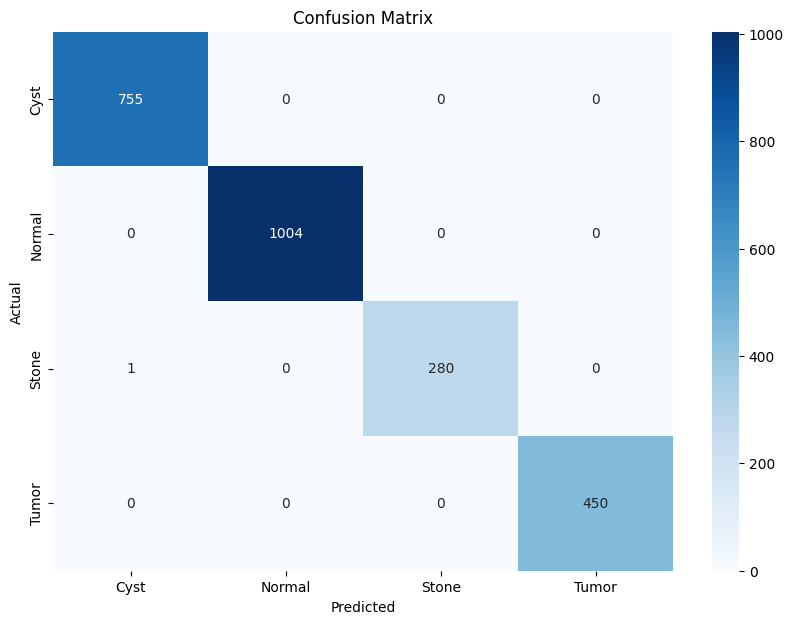

In [56]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for original_images, noisy_images, labels, noise_types in val_loader:
        noisy_images, labels = noisy_images.to(device), labels.to(device)
        outputs = model(noisy_images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [68]:
print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       755
      Normal       1.00      1.00      1.00      1004
       Stone       1.00      1.00      1.00       281
       Tumor       1.00      1.00      1.00       450

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



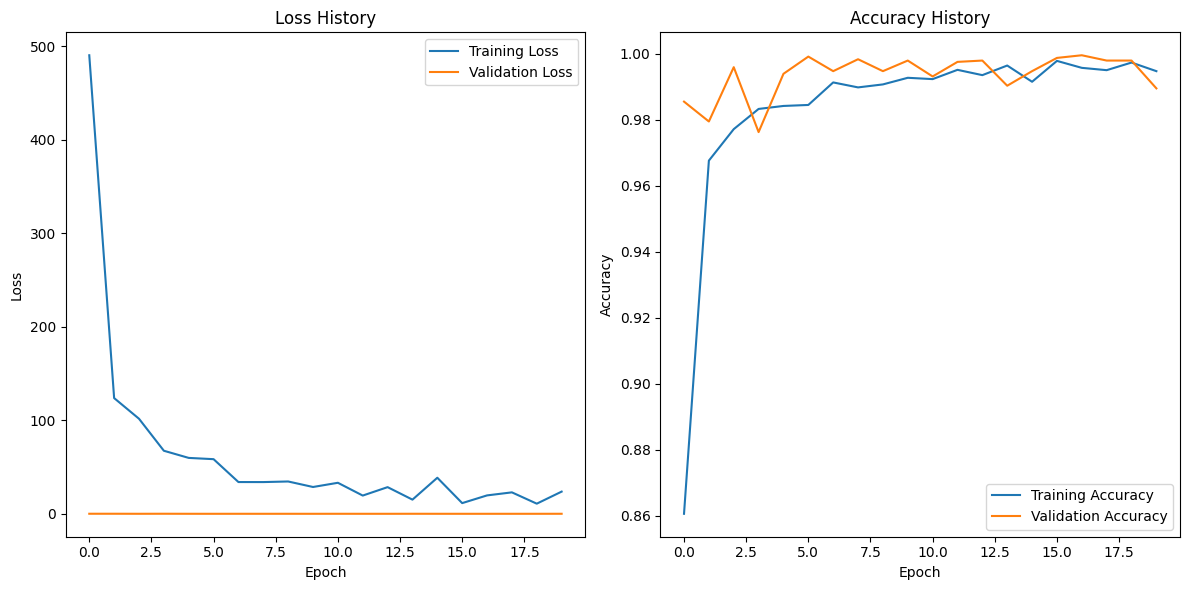

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

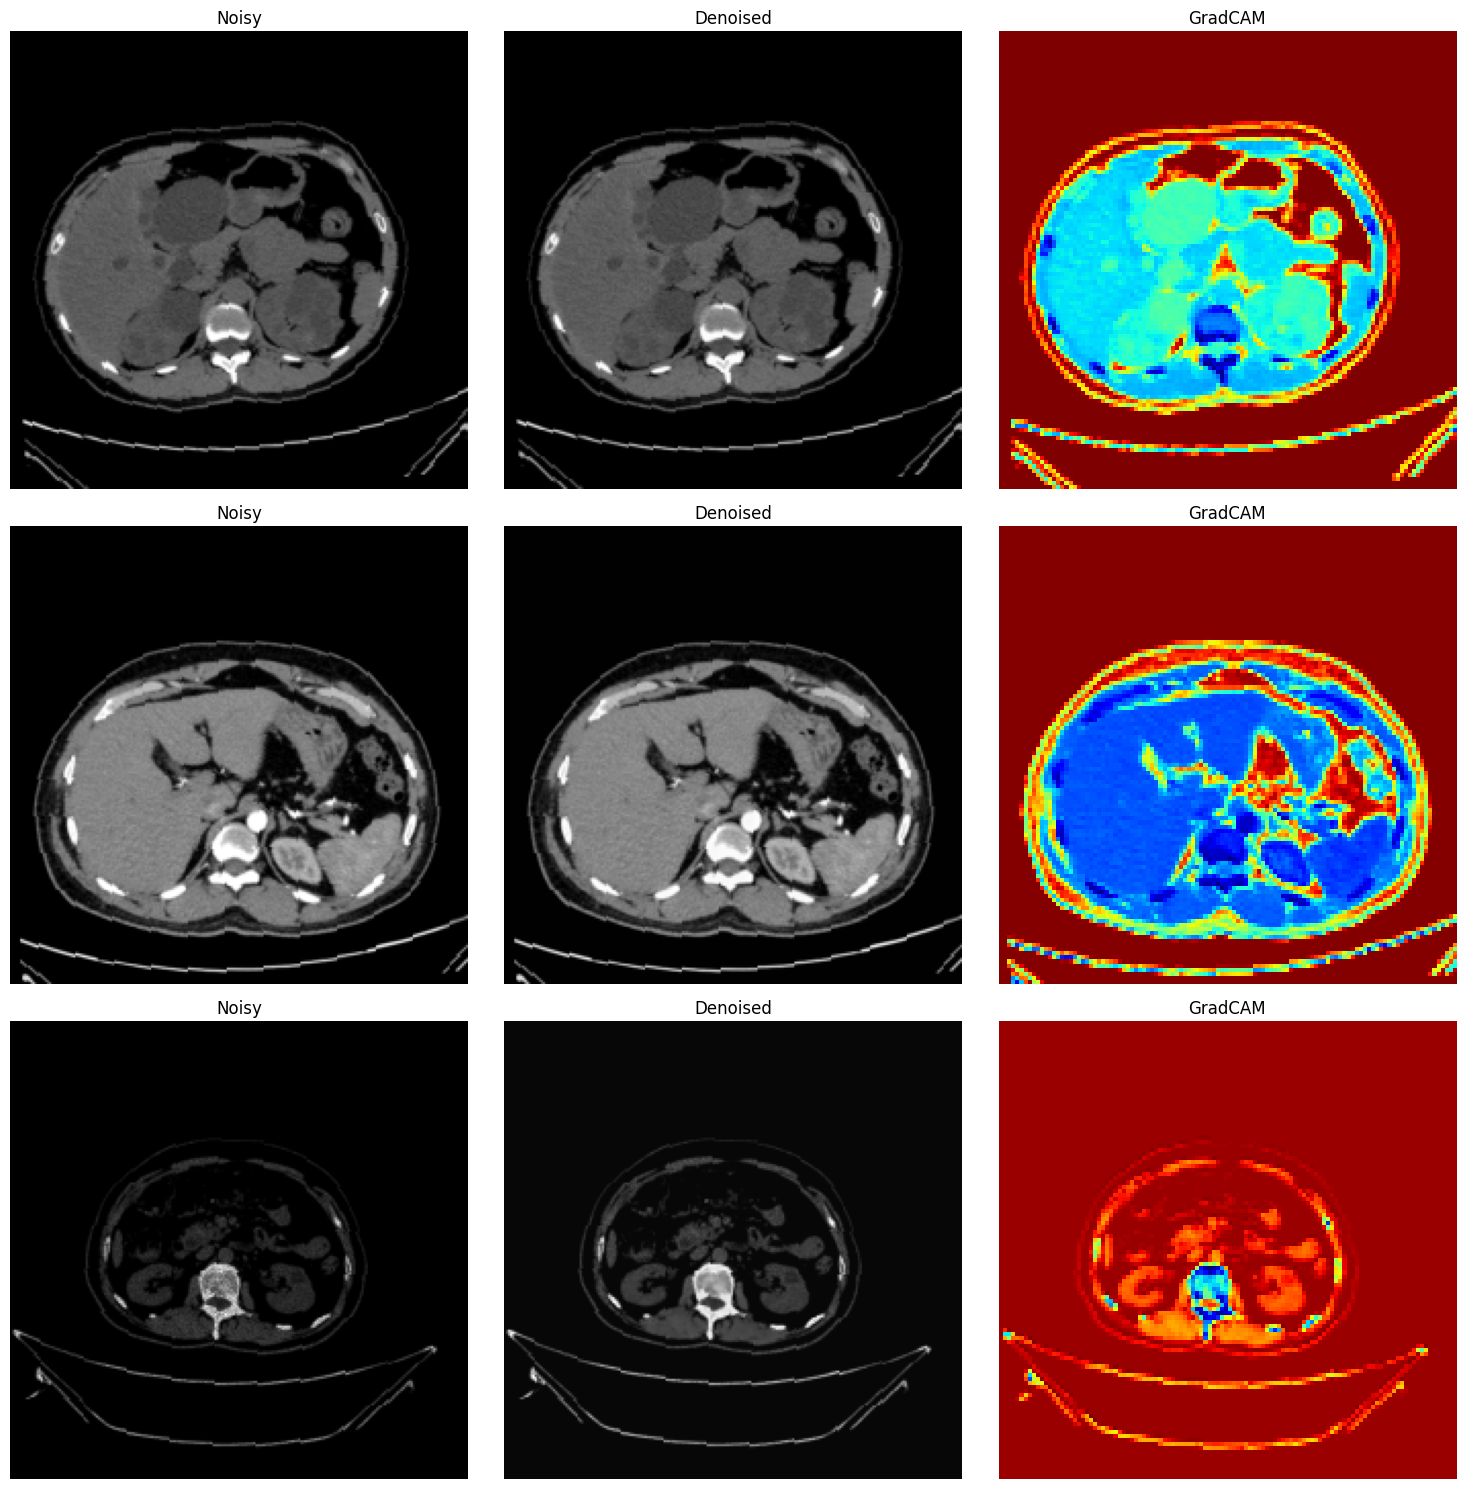

In [58]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[0])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

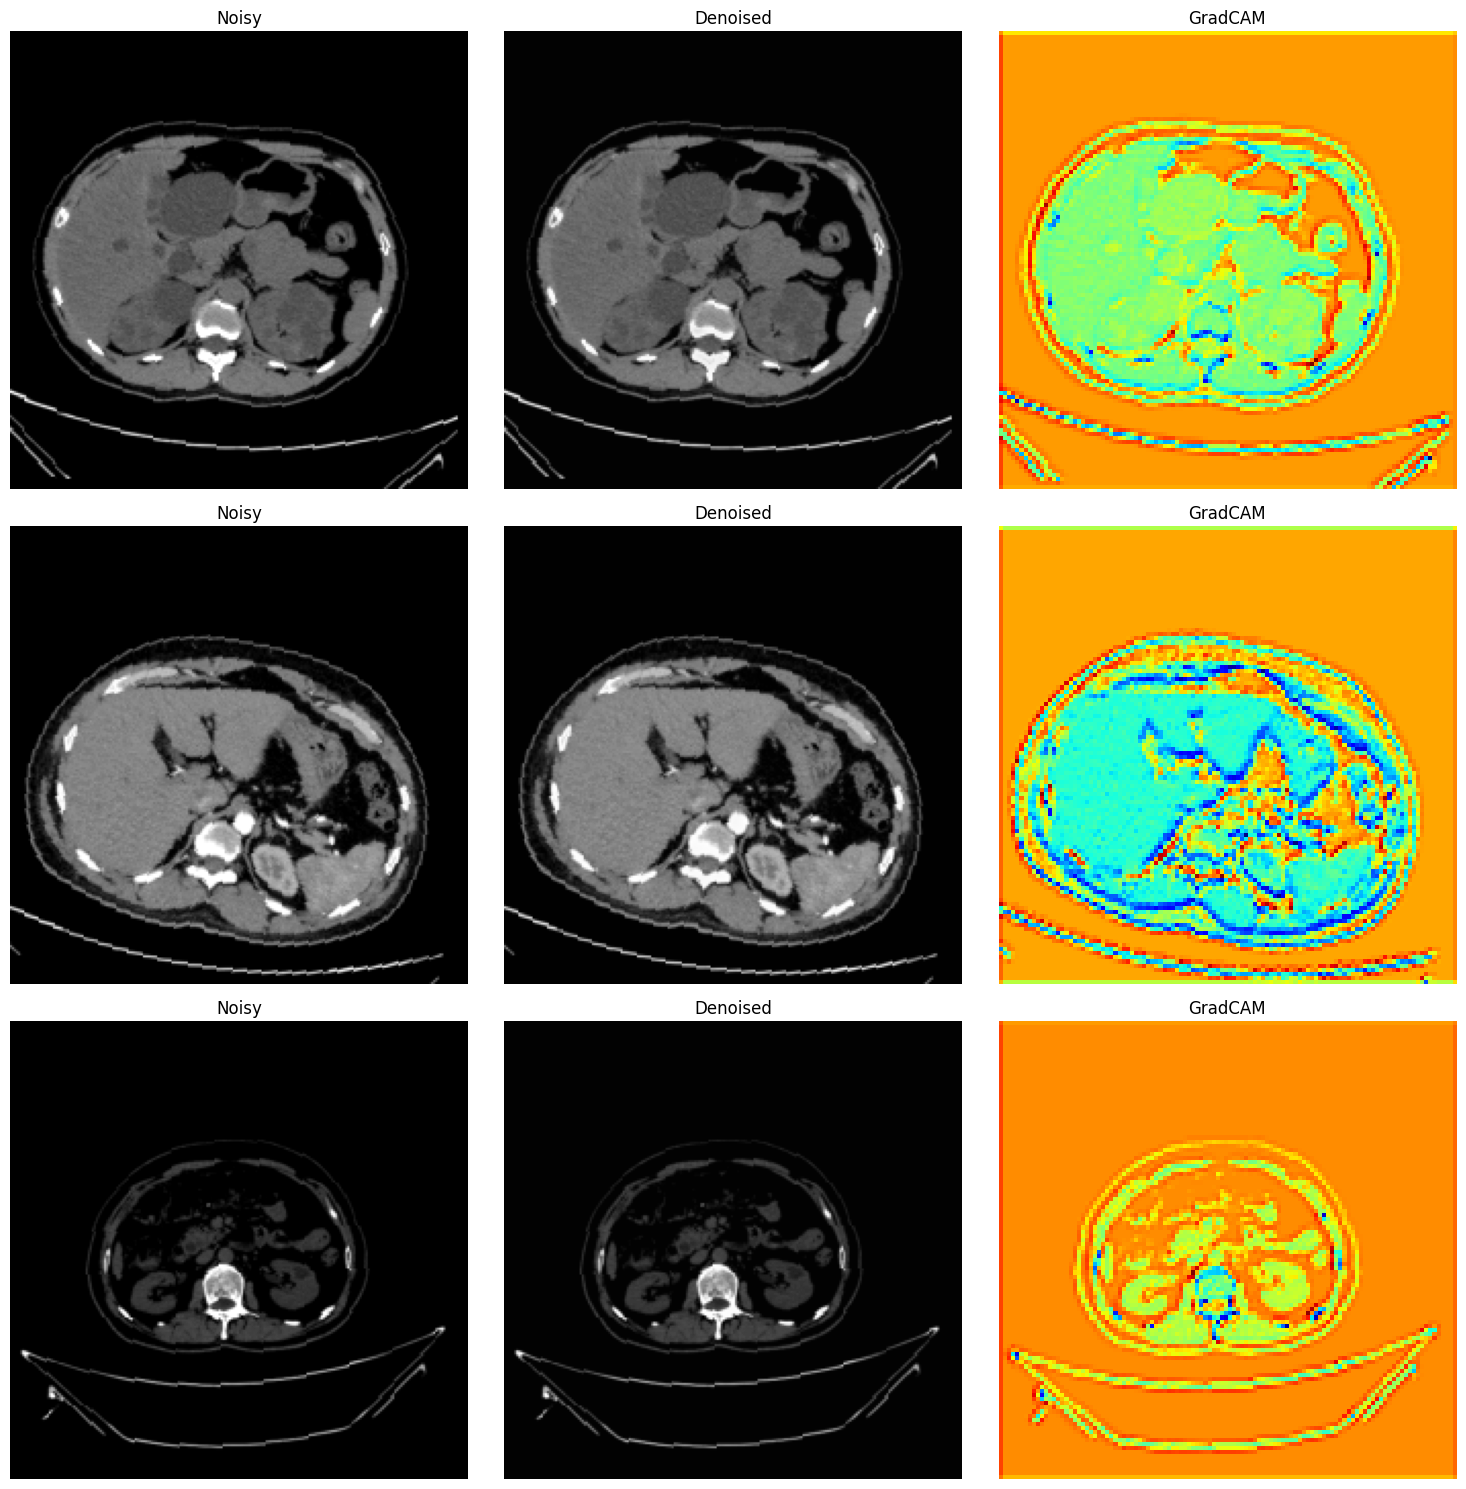

In [59]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[1])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

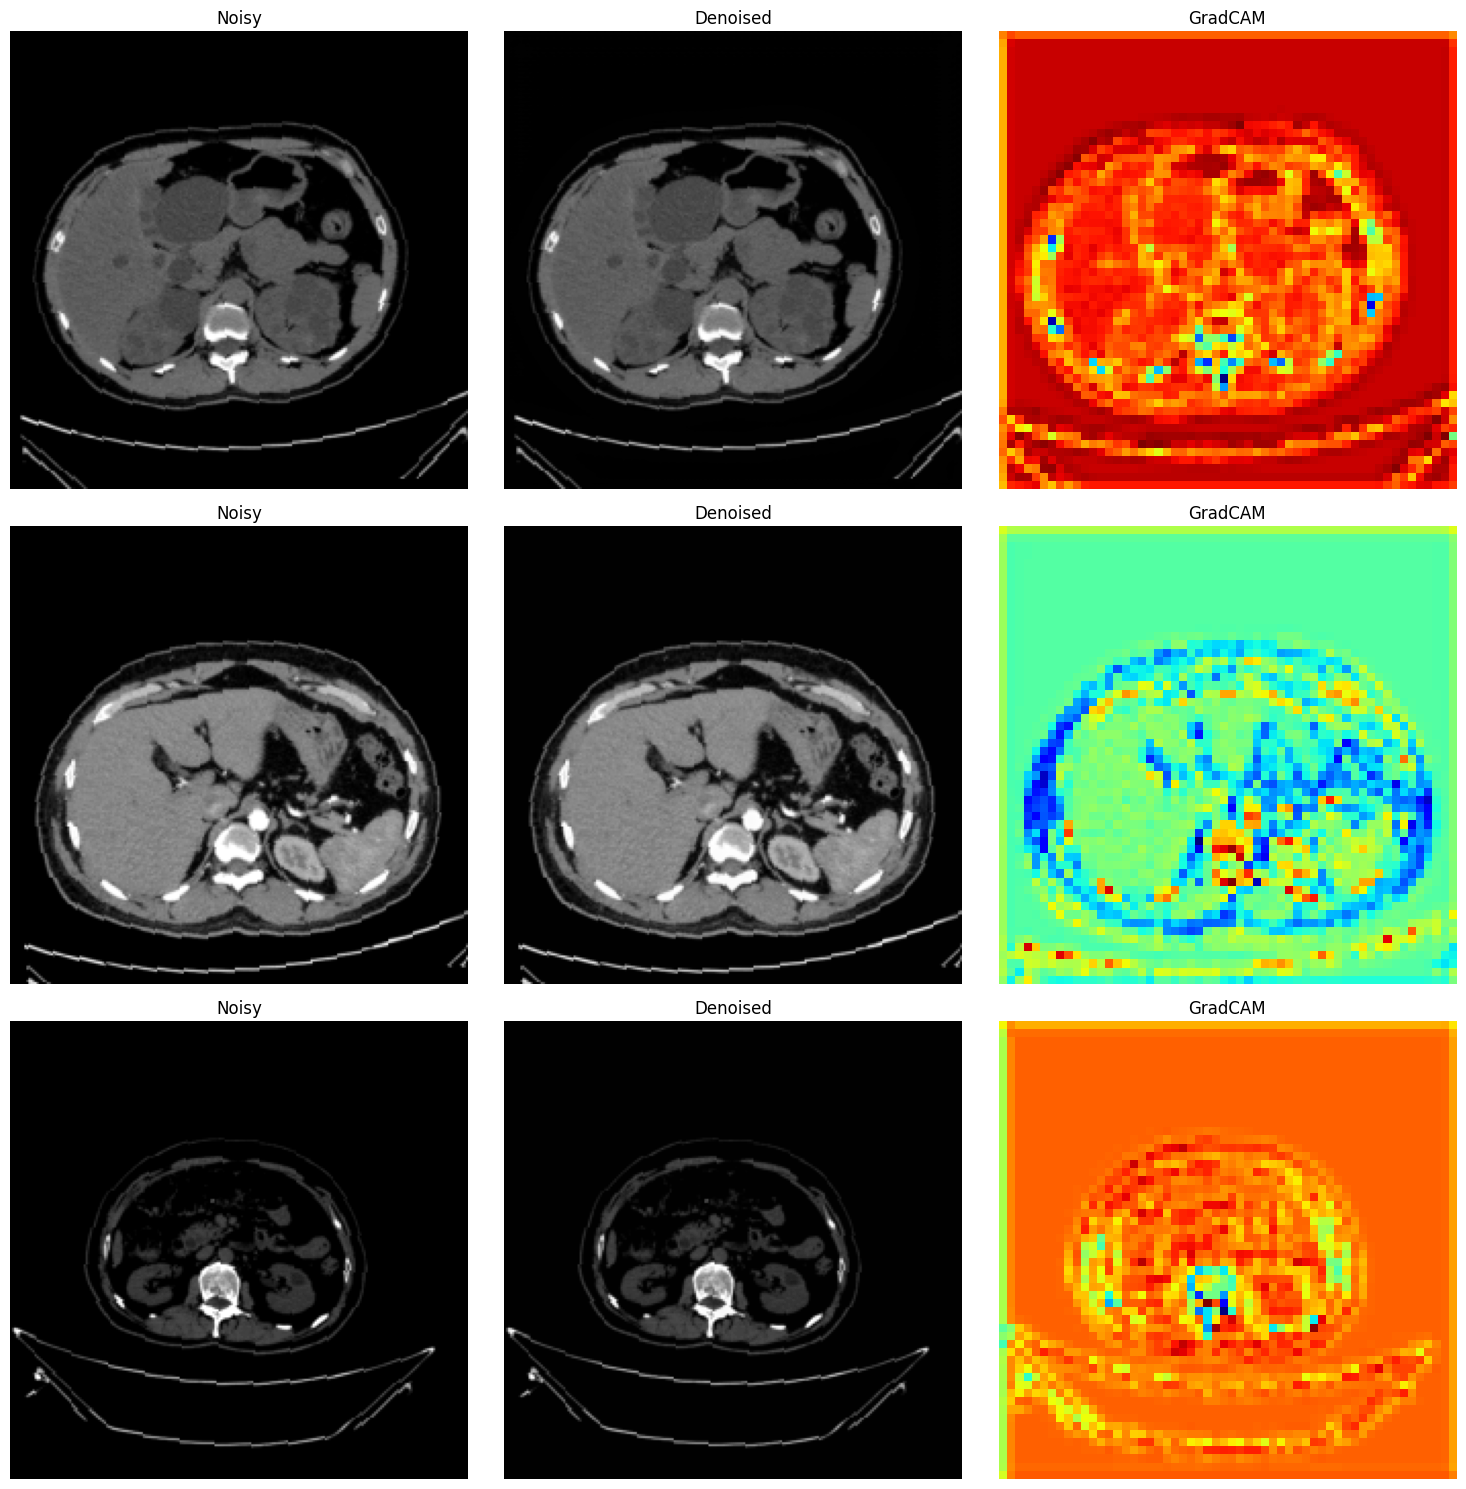

In [60]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[2])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [61]:
print(model.features)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

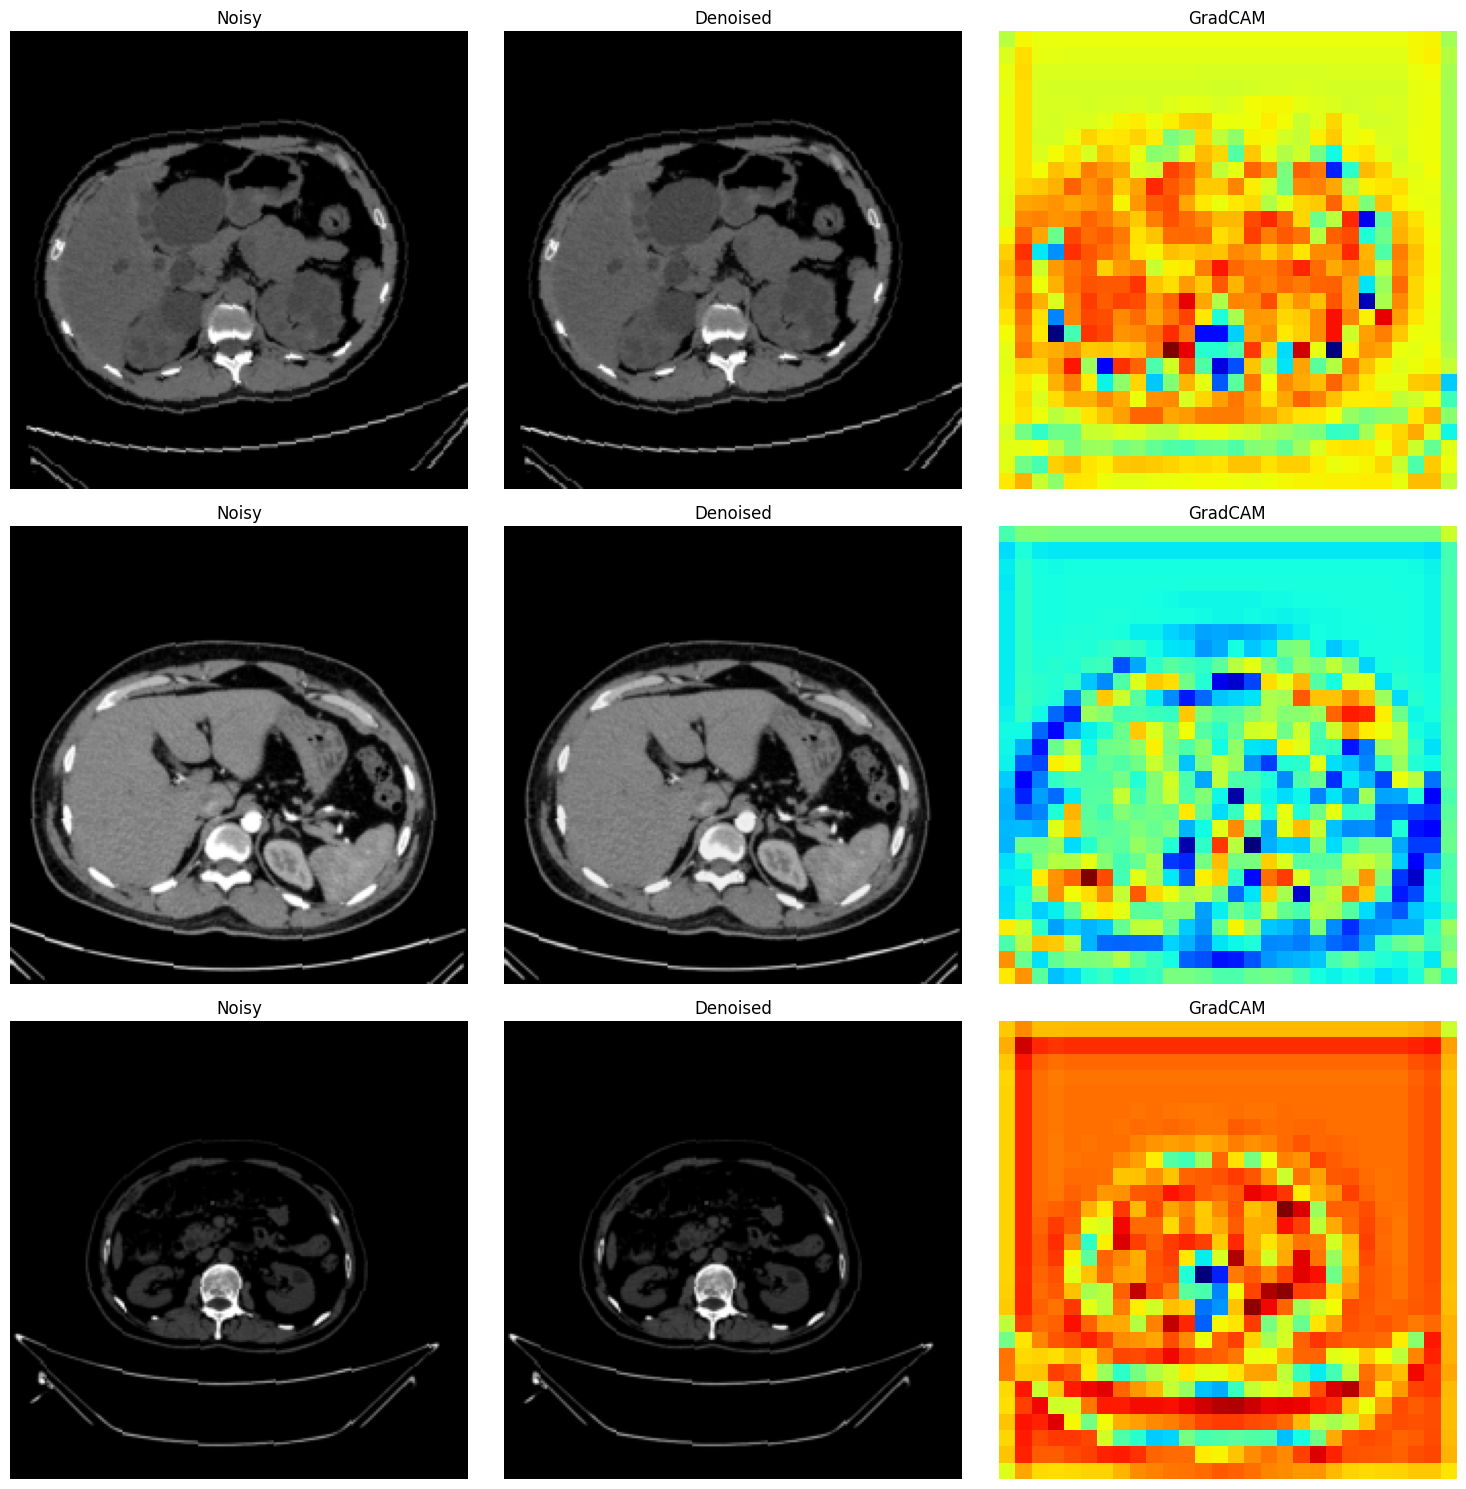

In [62]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[3])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

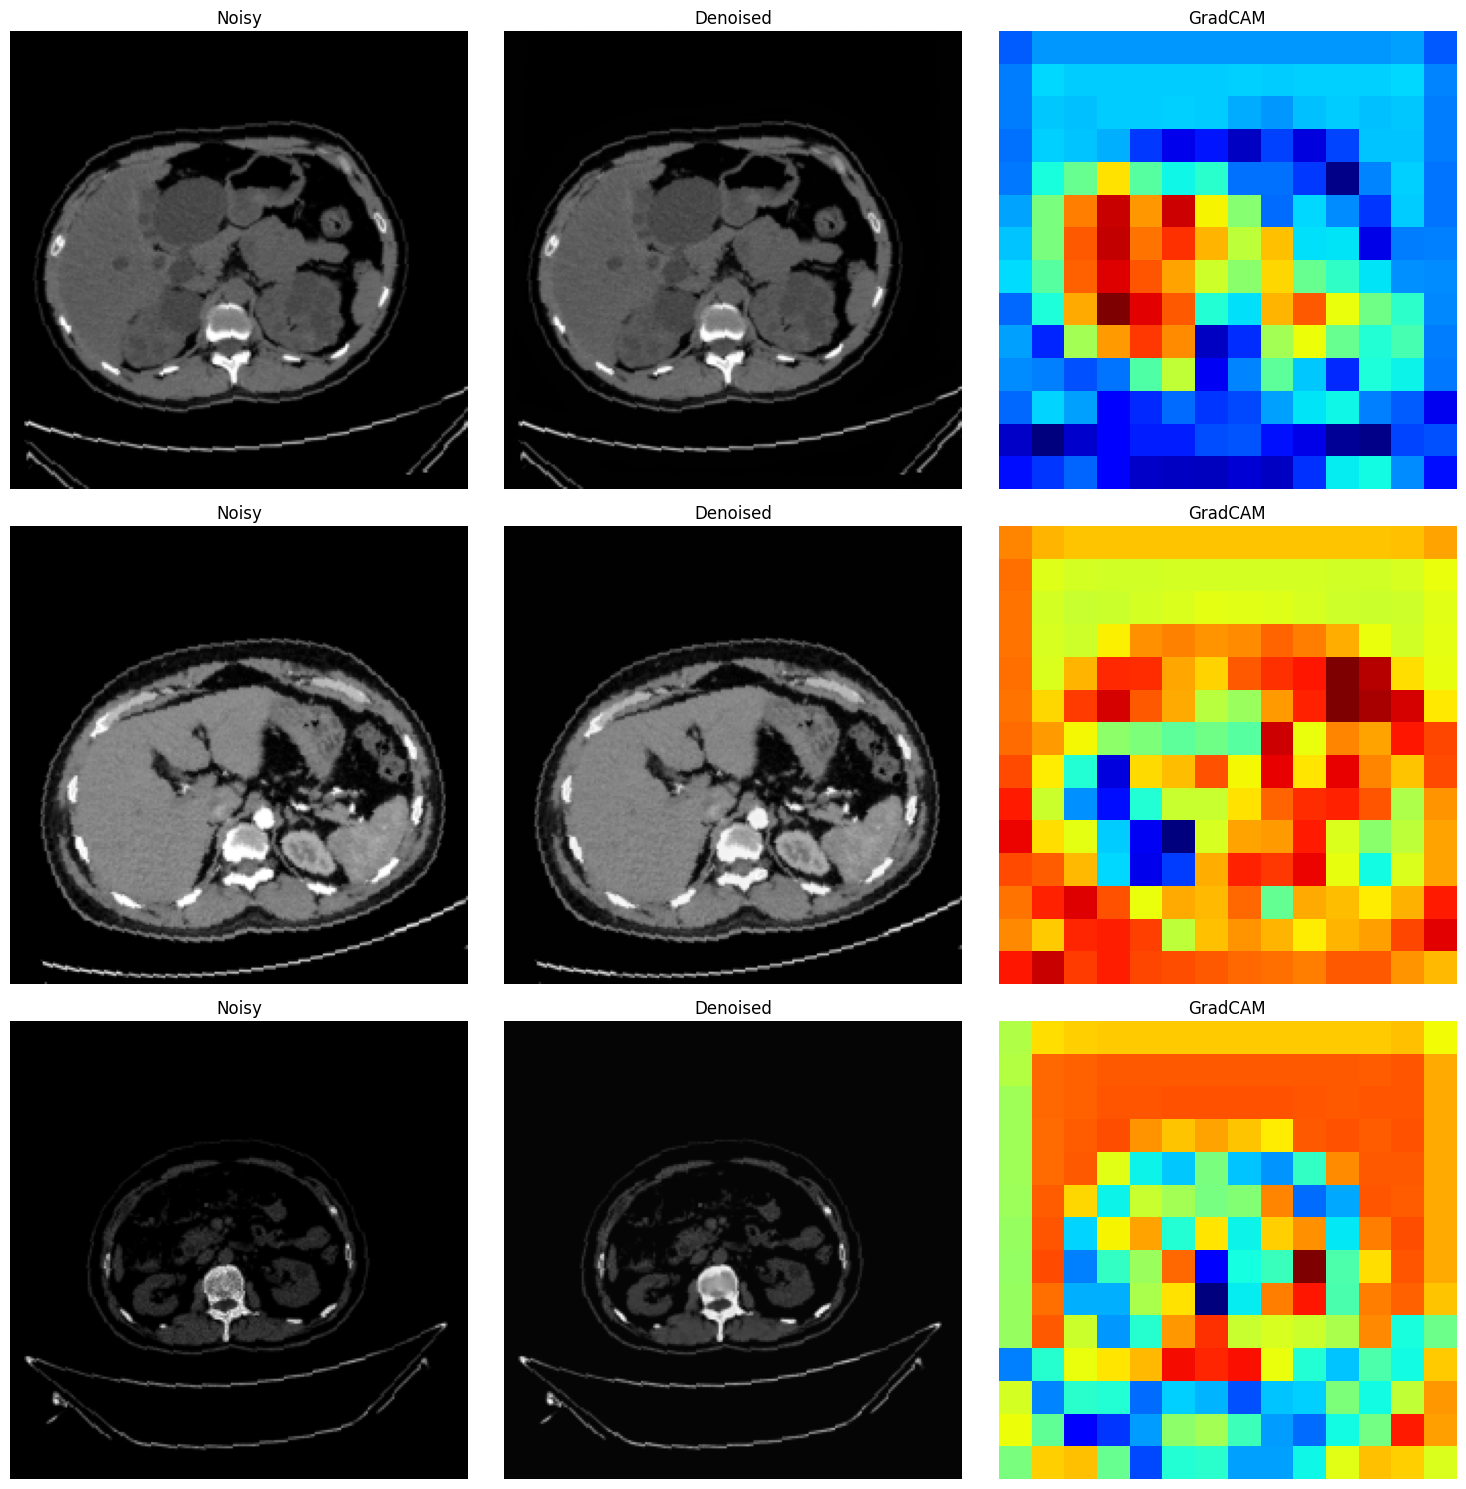

In [63]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[4])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

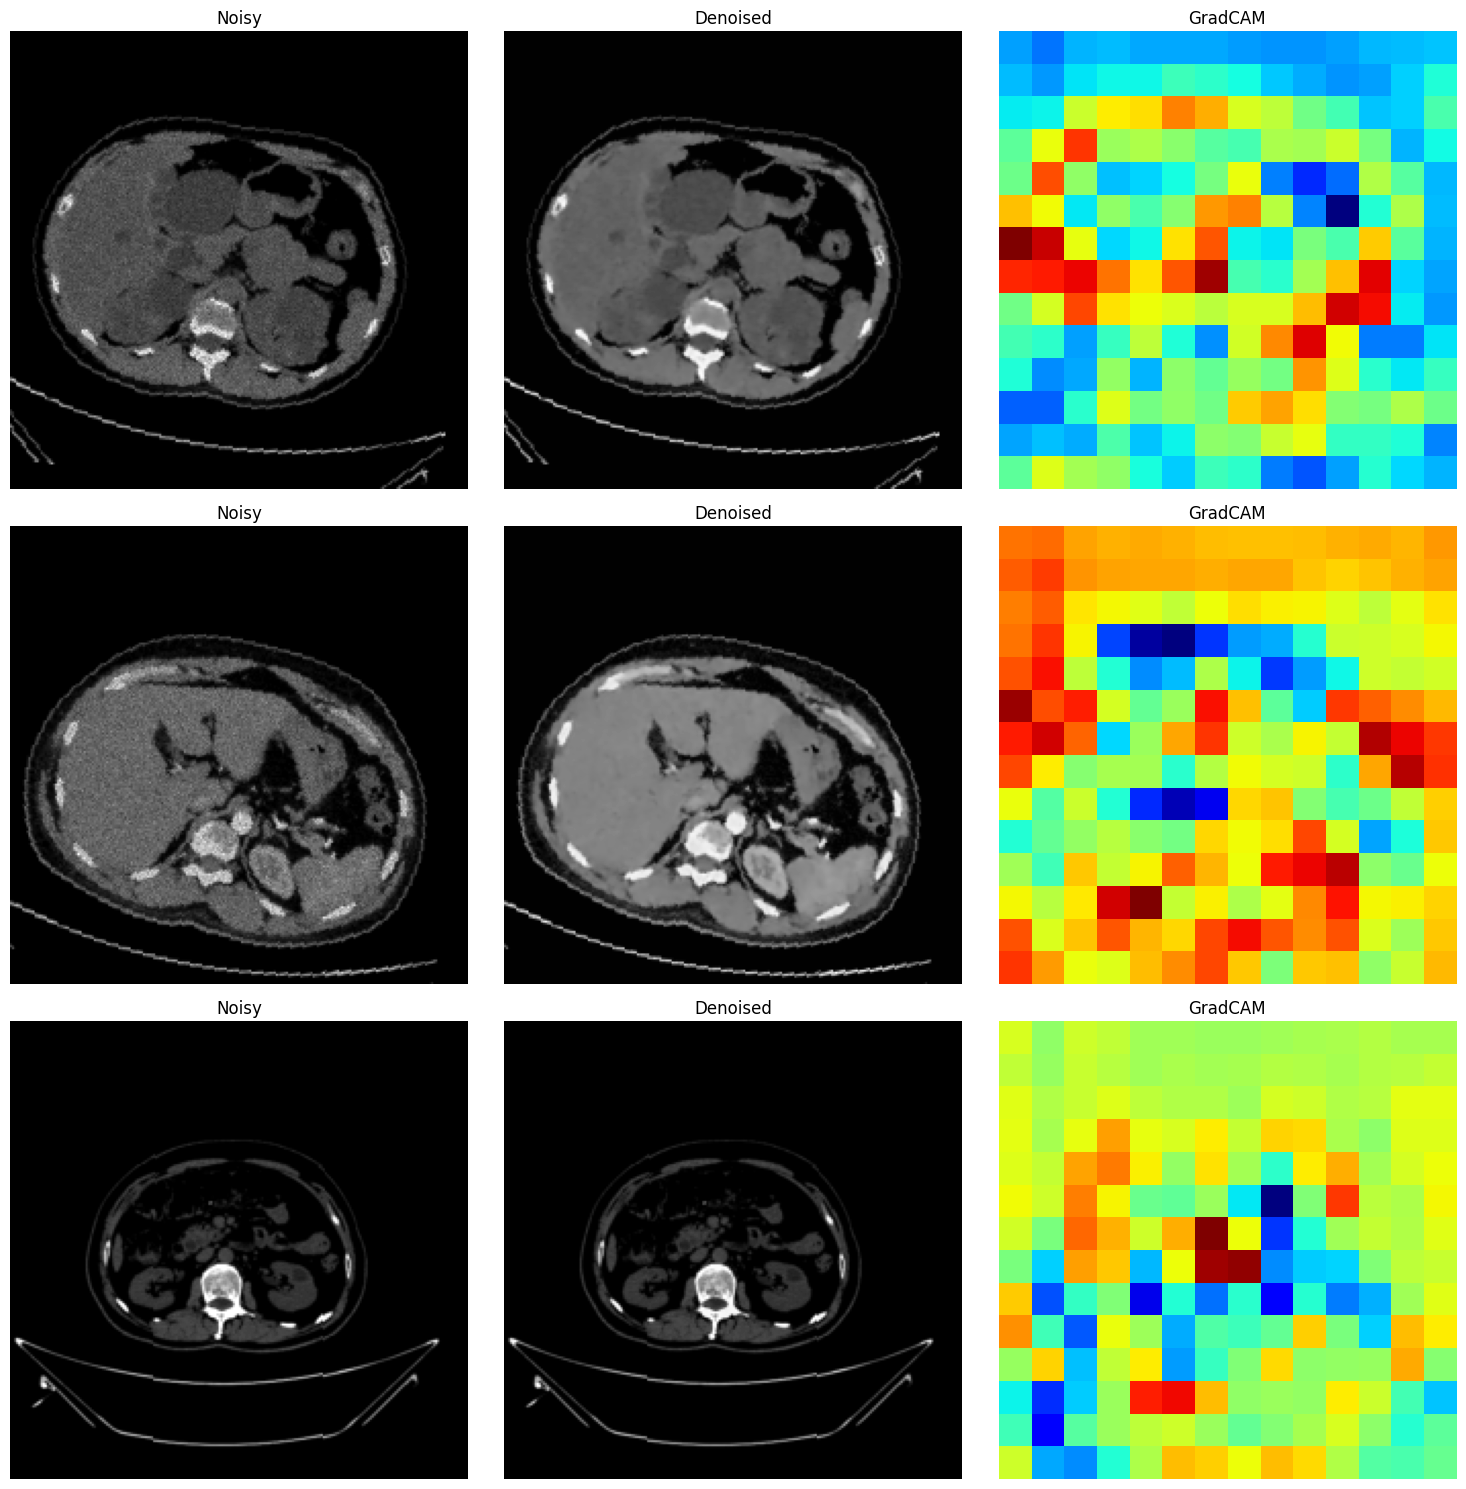

In [64]:
def get_gradcam_attr(model, input, layer):
    model.eval()
    model.to(device)
    input = input.to(device)
    layer_gc = LayerGradCam(model, layer)
    attr = layer_gc.attribute(input, target=1)
    return attr

data_iter = iter(val_loader)
original_images, noisy_images, labels, noise_types = next(data_iter)
original_images = original_images.to(device)
noisy_images = noisy_images.to(device)
denoised_images = generator(noisy_images)
labels = labels.to(device)

attr = get_gradcam_attr(model, denoised_images, model.features[5])
attr = attr.cpu().detach().numpy()
denoised_images = denoised_images.cpu().detach().numpy()

num_images = len(original_images)
rows = int(np.ceil(num_images / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

for i in range(num_images):
    ax = axes[i // 3, 0]
    ax.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    
    ax = axes[i // 3, 1]
    ax.imshow(denoised_images[i].squeeze(), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
    
    ax = axes[i // 3, 2]
    ax.imshow(attr[i].squeeze(), cmap='jet')
    ax.set_title('GradCAM')
    ax.axis('off')

plt.tight_layout()
plt.show()

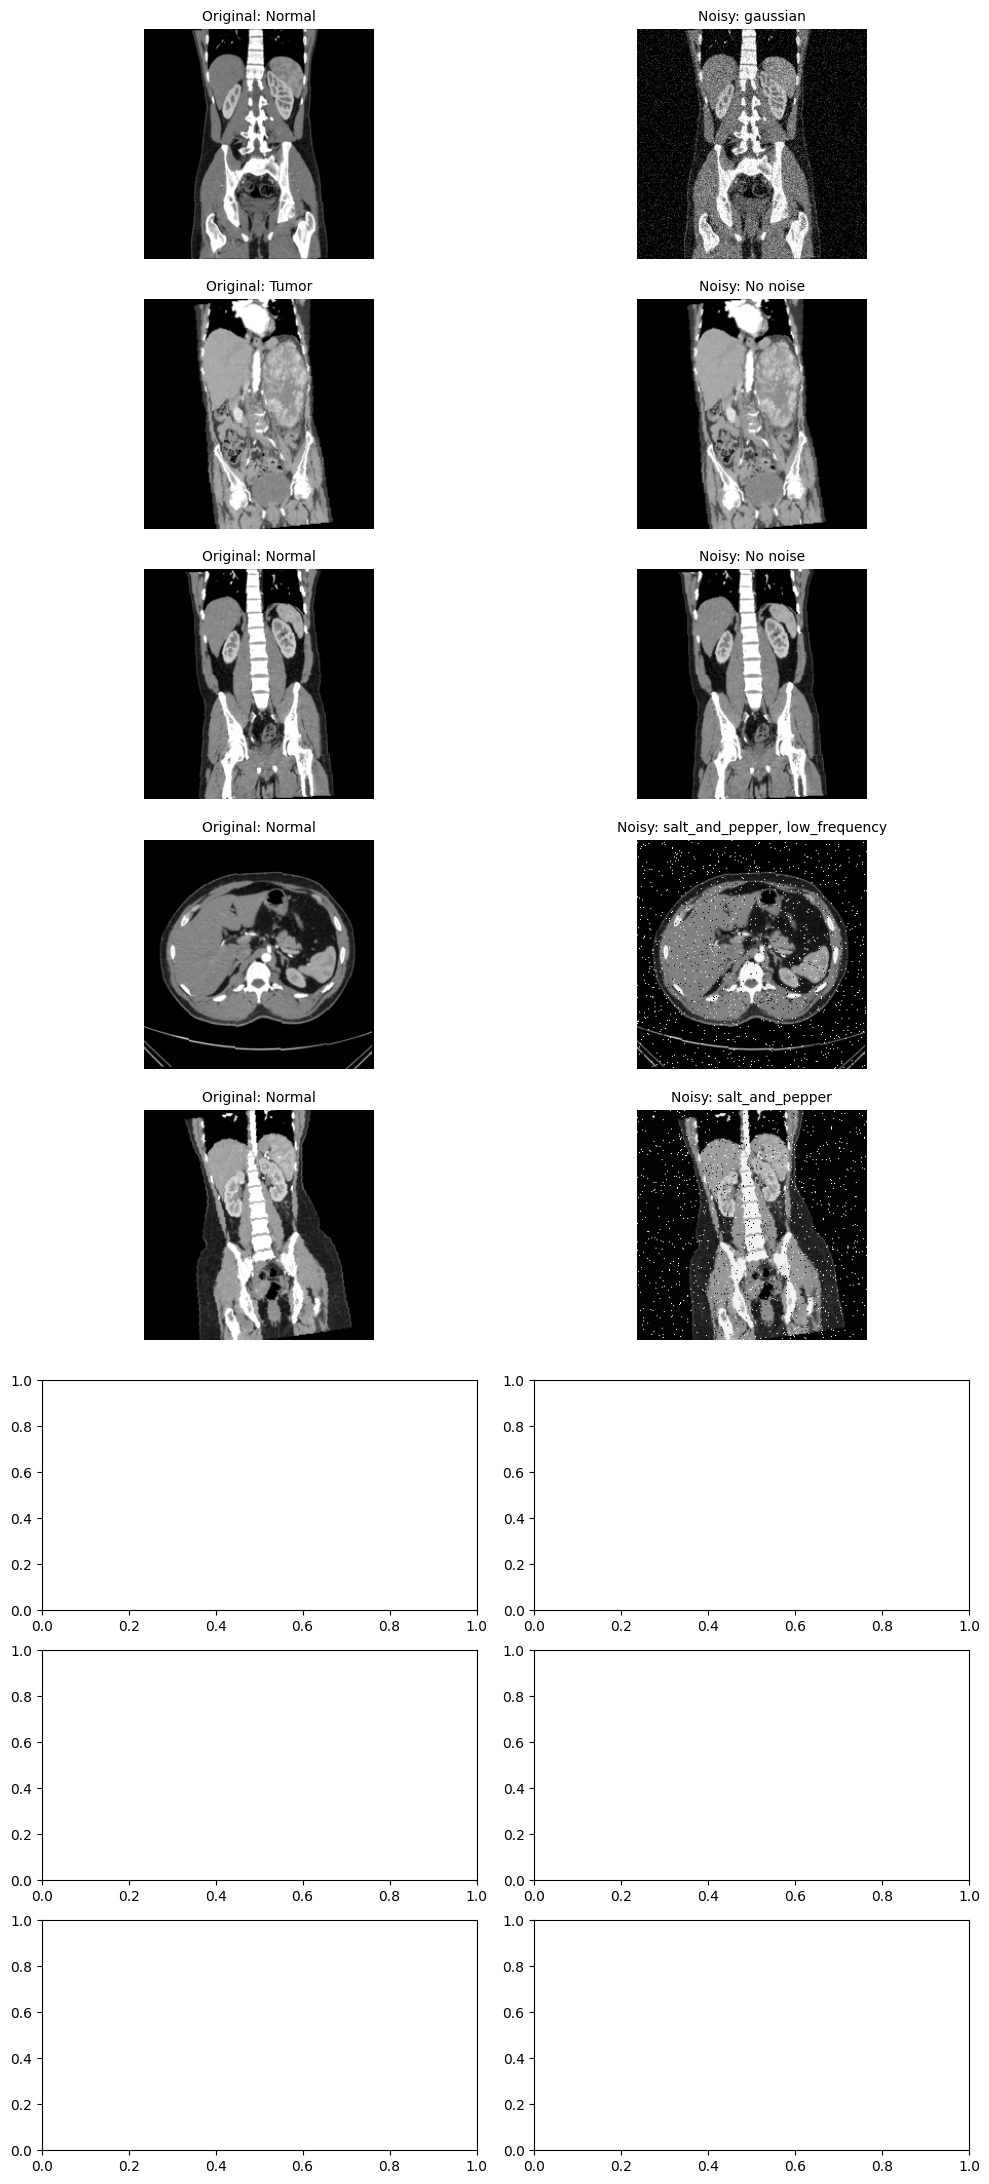

In [67]:
def visualize_original_and_noisy_images(data_loader):
    data_iter = iter(data_loader)
    original_images, noisy_images, labels, noise_types = next(data_iter)
    
    original_images = original_images.numpy().clip(0, 1)
    noisy_images = noisy_images.numpy().clip(0, 1)

    noise_type_dict = {}
    for i, noise_type in enumerate(noise_types):
        if noise_type not in noise_type_dict:
            noise_type_dict[noise_type] = []
        noise_type_dict[noise_type].append(i)

    fig, axes = plt.subplots(len(noise_type_dict) * 2, 2, figsize=(10, len(noise_type_dict) * 6))

    row = 0
    for noise_type, indices in noise_type_dict.items():
        for i in range(min(2, len(indices))):
            idx = indices[i]
            ax = axes[row, 0]
            ax.imshow(original_images[idx].squeeze(), cmap='gray')
            ax.set_title(f'Original: {dataset.classes[labels[idx]]}', fontsize=10)
            ax.axis('off')
            ax = axes[row, 1]
            ax.imshow(noisy_images[idx].squeeze(), cmap='gray')
            ax.set_title(f'Noisy: {noise_type}', fontsize=10)
            ax.axis('off')
            row += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

visualize_original_and_noisy_images(train_loader)